<a href="https://colab.research.google.com/github/AnnePierceDataAnalyst/Data-cleaning-Covid/blob/main/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sommaire

1. Charger librairies, fichier, créer colonnes
2. Prétraitements
3. Embedding & TSNE


# 1. Charger librairies,fichier, créer colonnes

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.0 MB/s eta 0:00:00


In [ ]:
# load dependencies
from transformers import AutoTokenizer, TFBertModel

# AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import os

# Pour segmenter et représenter graphiquement
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns


In [ ]:
url = '/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv'
df0 = pd.read_csv(url)
df0.head(2)



,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
# Les valeurs de cette colonne sont dans des [], je les enlève
df0['product_category_string'] = df0['product_category_tree'].str.lstrip('["').str.rstrip('"]')

# Ne garder que le premier niveau (variable cible)
df0['Category1']=df0['product_category_string'].str.split('>>').str[0]

In [ ]:
# Restriction aux colonnes pertinentes
df= df0[['uniq_id','Category1','description']]

# 2. Prétraitement

In [ ]:
# Définir BERT tokenizer & classifier
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=False, num_labels=7)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tokenizer les 1050 descriptions
tokenizer_output = bert_tokenizer(df["description"].tolist(), 
                                  truncation=True,                                  
                                  max_length=500, 
                                  padding='max_length',
                                  return_tensors='np')

# les mettre au format array
tokenizer_output_np = np.array([
    tokenizer_output['input_ids'], 
    tokenizer_output['attention_mask']
])
print(tokenizer_output_np.shape)
     

(2, 1050, 500)


In [ ]:
df['description']

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

In [ ]:
tokenizer_output_np

array([[[  101,  3145,  2838, ...,     0,     0,     0],
        [  101, 15480,  1997, ...,     0,     0,     0],
        [  101,  3145,  2838, ...,     0,     0,     0],
        ...,
        [  101,  4965, 19169, ...,     0,     0,     0],
        [  101,  4965,  2813, ...,     0,     0,     0],
        [  101,  4965, 19169, ...,     0,     0,     0]],

       [[    1,     1,     1, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        ...,
        [    1,     1,     1, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0]]])

# 3. Embedding

In [ ]:
# Définir modèle
bert_model = TFBertModel.from_pretrained(
    'bert-base-uncased', 
    trainable=False, 
    num_labels=7)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFBertModel.from_pretrained(model_type)
sentences = df['description'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)


    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
 
     
    return features_bert, last_hidden_states_tot

In [ ]:
# Création des features (execution = 5 minutes))

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step


In [ ]:
# Calcul ARI
def ARI_fct(features) :
    # Réduire dimensionalité
    num_labels=7
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)

    print("ARI : ", ARI)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(20,8))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1',s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1', s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=[1,2,3,4,5,6,7], loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [ ]:
l_cat = list(set(df['Category1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['Category1'])) for i in range(len(df))]

catégories :  ['Baby Care ', 'Home Furnishing ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ', 'Computers ', 'Beauty and Personal Care ', 'Watches ']


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3239


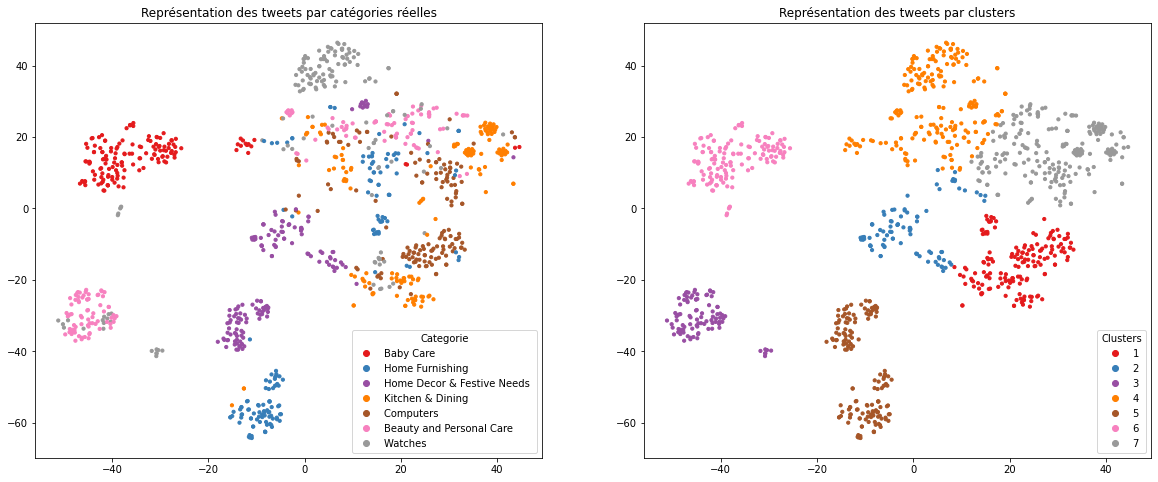

ARI :  0.3239


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)